In [1]:
import json
import numpy as np
import pickle
import pandas as pd
from scipy import stats
from scipy.spatial.distance import pdist
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
from classes.behavioural_experiment import Behavioural_experiment
from classes.participant import Participant
from classes.trial import Trial
from classes.models import presets
from methods.extraction import vecToDict, dictToVec
from statannot import add_stat_annotation
from statannotations.Annotator import Annotator

pd.set_option('display.max_columns', None)
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from statannot import add_stat_annotation
from statannotations.Annotator import Annotator

pd.set_option('display.max_columns', None)
%matplotlib inline

In [3]:

df = pd.read_csv('./data/df_participants.csv')
sample_size = len(df)
print('Sample size:', sample_size)
experiments = ['experiment_1', 'experiment_2', 'experiment_3', 'experiment_4']
sample_size_exps = [len(df[df.experiment == exp]) for exp in experiments]
print(sample_size_exps)

df_trials = pd.read_csv('./data/df_trials_wprior.csv')

interventions = pd.read_csv('./data/df_interventions.csv')

## Demographics
demos = pd.read_csv('./data/df_demographics.csv')

experiments = df.experiment.unique().tolist()
print(experiments)

df_long_2 = pd.read_csv('./data/accuracy_lf_exp2.csv')
df_long_2_ham = pd.read_csv('./data/editdist_lf_exp2.csv')

df_long_3 = pd.read_csv('./data/accuracy_lf_exp3_wprior.csv')
df_long_3_ham = pd.read_csv('./data/editdist_lf_exp3_wprior.csv')
df_long_3_ham['difficulty'] = df_long_3_ham['difficulty'].replace({'congruent':1.0, 'incongruent':2.0})
#df_long_3['hamming'] = df_long_3_ham.accuracy.to_list()

pids = df_long_3.participant.unique()
diff = ['congruent', 'incongruent']

df_long_3['utid'] = df_long_3.participant + '_' + df_long_3.difficulty.astype(str)
df_long_3_ham['utid'] = df_long_3_ham.participant + '_' + df_long_3_ham.difficulty.astype(str)

df_long_3['hamming'] = np.nan
df_long_3.loc[df_long_3.utid.isin(df_long_3_ham.utid), 'hamming'] = df_long_3_ham.loc[df_long_3_ham.utid.isin(df_long_3.utid), 'accuracy'].to_list()
df_long_3 = df_long_3.drop(['utid'], axis=1)


df_long_4 = pd.read_csv('./data/accuracy_lf_exp4_wprior.csv')
df_long_4_ham = pd.read_csv('./data/editdist_lf_exp4_wprior.csv')
df_long_4_ham['difficulty'] = df_long_4_ham['difficulty'].replace({'congruent':1.0, 'incongruent':2.0})

df_long_4['utid'] = df_long_4.participant + '_' + df_long_4.difficulty.astype(str)
df_long_4_ham['utid'] = df_long_4_ham.participant + '_' + df_long_4_ham.difficulty.astype(str)

df_long_4['hamming'] = np.nan
df_long_4.loc[df_long_4.utid.isin(df_long_4_ham.utid), 'hamming'] = df_long_4_ham.loc[df_long_4_ham.utid.isin(df_long_4.utid), 'accuracy'].to_list()
df_long_4 = df_long_4.drop(['utid'], axis=1)


Sample size: 420
[60, 121, 121, 118]
['experiment_1', 'experiment_2', 'experiment_3', 'experiment_4']


# Demographics

In [4]:

selections = [
    ['experiment_1', 'experiment_2', 'experiment_3', 'experiment_4'],
    ['experiment_1'],
    ['experiment_2'],
    ['experiment_3'],
    ['experiment_4'],
]

for experiment in selections:
    demos_local = demos[demos.experiment.isin(experiment)]
    print(f'Selection: {experiment}')
    print(f'Gender: {demos_local[demos_local.gender == 1].shape[0]} males (N = {demos_local.shape[0]})')
    print(f'Age: {demos_local.age.mean()}, sd={demos_local.age.std()}\n')

Selection: ['experiment_1', 'experiment_2', 'experiment_3', 'experiment_4']
Gender: 264 males (N = 420)
Age: 26.93095238095238, sd=8.410840490360656

Selection: ['experiment_1']
Gender: 36 males (N = 60)
Age: 26.4, sd=6.656715737267114

Selection: ['experiment_2']
Gender: 78 males (N = 121)
Age: 24.578512396694215, sd=6.301788193462368

Selection: ['experiment_3']
Gender: 86 males (N = 121)
Age: 28.917355371900825, sd=9.536409856316915

Selection: ['experiment_4']
Gender: 64 males (N = 118)
Age: 27.576271186440678, sd=9.30711223279614



# Descriptive and general link recovery statistics

In [5]:
experiments = [
    'experiment_1', 
    'experiment_2', 
    'experiment_3', 
    'experiment_4'
]

for experiment in experiments:
    df_exp = df[df.experiment == experiment]

    print(f'Data for {experiment}')
    # Links recovered
    t, p = stats.ttest_1samp(df_exp.genCorr, 1/5)
    degf = df_exp.genCorr.size - 1
    print(f'Links recovered: {np.round(df_exp.genCorr.mean(), 6)}, t({degf})={np.round(t, 6)}, p={np.round(p, 6)}, chance level={1/5}')

    # positive links recovered
    t, p = stats.ttest_1samp(df_exp.posCorr, 2/6)
    degf = df_exp.posCorr.size - 1
    print(f'Positive links recovered: {np.round(df_exp.posCorr.mean(), 6)}, t({degf})={np.round(t, 6)}, p={np.round(p, 6)}, chance level={np.round(2/6, 2)}')

    # negative links recovered
    t, p = stats.ttest_1samp(df_exp.negCorr, 2/6)
    degf = df_exp.negCorr.size - 1
    print(f'Negative links recovered: {np.round(df_exp.negCorr.mean(), 6)}, t({degf})={np.round(t, 6)}, p={np.round(p, 6)}, chance level={np.round(2/6, 2)}')

    t, p = stats.ttest_ind(df_exp.posCorr, df_exp.negCorr)
    degf = df_exp.posCorr.size - 1 + df_exp.negCorr.size - 1
    print(f'Difference negative positive: diff={df_exp.posCorr.mean() - df_exp.negCorr.mean()}, t({degf})={np.round(t, 6)}, p={np.round(p, 6)}')
    
    # weak links recovered
    t, p = stats.ttest_1samp(df_exp.weakCorr, 2/6)
    degf = df_exp.weakCorr.size - 1
    print(f'Weak links recovered: {np.round(df_exp.weakCorr.mean(), 6)}, t({degf})={np.round(t, 6)}, p={np.round(p, 6)}, chance level={np.round(2/6, 2)}')

    # strong links recovered
    t, p = stats.ttest_1samp(df_exp.stgCorr, 2/6)
    degf = df_exp.stgCorr.size - 1
    print(f'Strong links recovered: {np.round(df_exp.stgCorr.mean(), 6)}, t({degf})={np.round(t, 6)}, p={np.round(p, 6)}, chance level={np.round(2/6, 2)}')

    t, p = stats.ttest_ind(df_exp.weakCorr, df_exp.stgCorr)
    degf = df_exp.weakCorr.size - 1 + df_exp.stgCorr.size - 1
    print(f'Difference weak strong: diff={df_exp.weakCorr.mean() - df_exp.stgCorr.mean()}, t({degf})={np.round(t, 6)}, p={np.round(p, 6)}')
    

    print(f'Average time taken: mean={np.round(df_exp.time_taken.mean(), 6)}, std={np.round(df_exp.time_taken.std(), 6)}')


    # Order in trial
    if experiment[-1] in ['2', '3', '4']:
        if experiment[-1] == '2':
            for i, scenario in enumerate(['finance', 'estate', 'crime']):
                group_1 = df_exp[df_exp[f'{scenario}_cond_order'] == 1][f'{scenario}_acc']
                group_2 = df_exp[df_exp[f'{scenario}_cond_order'] == 2][f'{scenario}_acc']
                group_3 = df_exp[df_exp[f'{scenario}_cond_order'] == 3][f'{scenario}_acc']
            
                f, p = stats.f_oneway(group_1, group_2, group_3)
                print(f'Scenario {scenario} order effect: F={np.round(f, 6)}, p={np.round(p, 6)}')

        if experiment[-1] in ['3', '4']:
            for i, scenario in enumerate(['finance', 'crime']):
                group_1 = df_exp[df_exp[f'{scenario}_cond_order'] == 1][f'{scenario}_acc']
                group_2 = df_exp[df_exp[f'{scenario}_cond_order'] == 2][f'{scenario}_acc']
            
                f, p = stats.f_oneway(group_1, group_2)
                print(f'Scenario {scenario} order effect: F={np.round(f, 6)}, p={np.round(p, 6)}')


    print()


Data for experiment_1
Links recovered: 0.627778, t(59)=15.00285, p=0.0, chance level=0.2
Positive links recovered: 0.869444, t(59)=18.079466, p=0.0, chance level=0.33
Negative links recovered: 0.733333, t(59)=10.391082, p=0.0, chance level=0.33
Difference negative positive: diff=0.1361111111111113, t(118)=2.801131, p=0.005953
Weak links recovered: 0.4, t(59)=1.567907, p=0.122251, chance level=0.33
Strong links recovered: 0.504167, t(59)=4.171676, p=0.000101, chance level=0.33
Difference weak strong: diff=-0.10416666666666663, t(118)=-1.764555, p=0.080226
Average time taken: mean=26.836925, std=11.353627

Data for experiment_2
Links recovered: 0.51343, t(120)=23.064853, p=0.0, chance level=0.2
Positive links recovered: 0.75194, t(120)=20.015526, p=0.0, chance level=0.33
Negative links recovered: 0.732656, t(120)=16.662791, p=0.0, chance level=0.33
Difference negative positive: diff=0.019283746556473802, t(240)=0.606264, p=0.544912
Weak links recovered: 0.4264, t(120)=3.602131, p=0.00046

## Interventions descriptives

In [6]:
print('Across experiments')
print('Number of interventions:', len(interventions))
#print('Average number of interventions per participants:', len(interventions) / sample_size)
print('Average number of interventions per trial:', len(interventions) / (sample_size * 4))
print(f'Mean intervention length: {interventions.length_sec.mean()}')
print(f'Std intervention length: {interventions.length_sec.std()}')
print(f'Mean intervening time (in %): {interventions.groupby("utid").relative_length.sum().mean()}')
print(f'Std intervening time (in %): {interventions.groupby("utid").relative_length.sum().std()}')

Across experiments
Number of interventions: 14445
Average number of interventions per trial: 8.598214285714286
Mean intervention length: 3.1194877120110767
Std intervention length: 3.3999511722212374
Mean intervening time (in %): 0.435264321095458
Std intervening time (in %): 0.1924276896430353


In [7]:

for i, experiment in enumerate(experiments):
    interventions_exp = interventions[interventions.experiment == experiment]
    print(f'\n {experiment}')
    #print('Number of interventions:', len(interventions_exp))
    #print('Average number of interventions per participants:', len(interventions_exp) / sample_size_exps[i])
    print('Average number of interventions per trial:', len(interventions_exp) / (sample_size_exps[i] * 4))
    print(f'Mean intervention length: {interventions_exp.length_sec.mean()}')
    print(f'Std intervention length: {interventions_exp.length_sec.std()}')

    print(f'Mean intervening time (in %): {interventions_exp.groupby("utid").relative_length.sum().mean()}')
    print(f'Std intervening time (in %): {interventions_exp.groupby("utid").relative_length.sum().std()}')




 experiment_1
Average number of interventions per trial: 7.183333333333334
Mean intervention length: 3.377958236658933
Std intervention length: 3.955648078339496
Mean intervening time (in %): 0.4382600842865739
Std intervening time (in %): 0.19909165762183534

 experiment_2
Average number of interventions per trial: 8.196280991735538
Mean intervention length: 3.1592135114696247
Std intervention length: 3.3591206535103924
Mean intervening time (in %): 0.44241658312034854
Std intervening time (in %): 0.19078079244066132

 experiment_3
Average number of interventions per trial: 8.340909090909092
Mean intervention length: 3.023680951201387
Std intervention length: 3.3748375176930856
Mean intervening time (in %): 0.44029635400885836
Std intervening time (in %): 0.19530109427849526

 experiment_4
Average number of interventions per trial: 9.99364406779661
Mean intervention length: 3.073606105575578
Std intervention length: 3.227325941264477
Mean intervening time (in %): 0.42409262162731326


## Accuracy Distribution per experiment

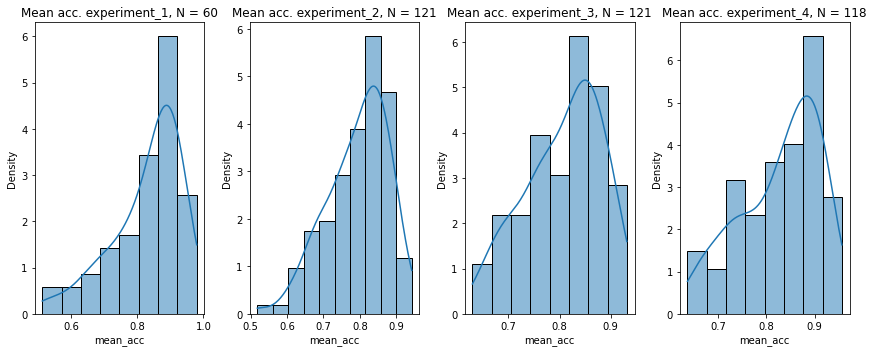

In [8]:
plt.figure(figsize=(12, 5))

for i in range(len(experiments)):
    plt.subplot(1, len(experiments), i+1)
    mean_acc = df[df.experiment == experiments[i]].mean_acc
    sns.histplot(mean_acc, kde=True, stat='density')
    plt.title(f'Mean acc. {experiments[i]}, N = {len(mean_acc)}')
plt.tight_layout()
plt.show()

In [9]:
color_dict = {
    'crime': 'cornflowerblue',
    'finance': 'darkorange',
    'estate': 'seagreen'
}

def gen_colors(labels, color_dict):
    return [color_dict[label] for label in labels]

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Congruent v.s. Incongruent: Custom statistical test, P_val:2.080e-02
Incongruent v.s. Implausible: Custom statistical test, P_val:9.000e-04
Congruent v.s. Implausible: Custom statistical test, P_val:9.000e-05
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Congruent v.s. Incongruent: Custom statistical test, P_val:9.700e-03
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Incongruent v.s. Congruent: Custom statistical test, P_val:3.000e-02


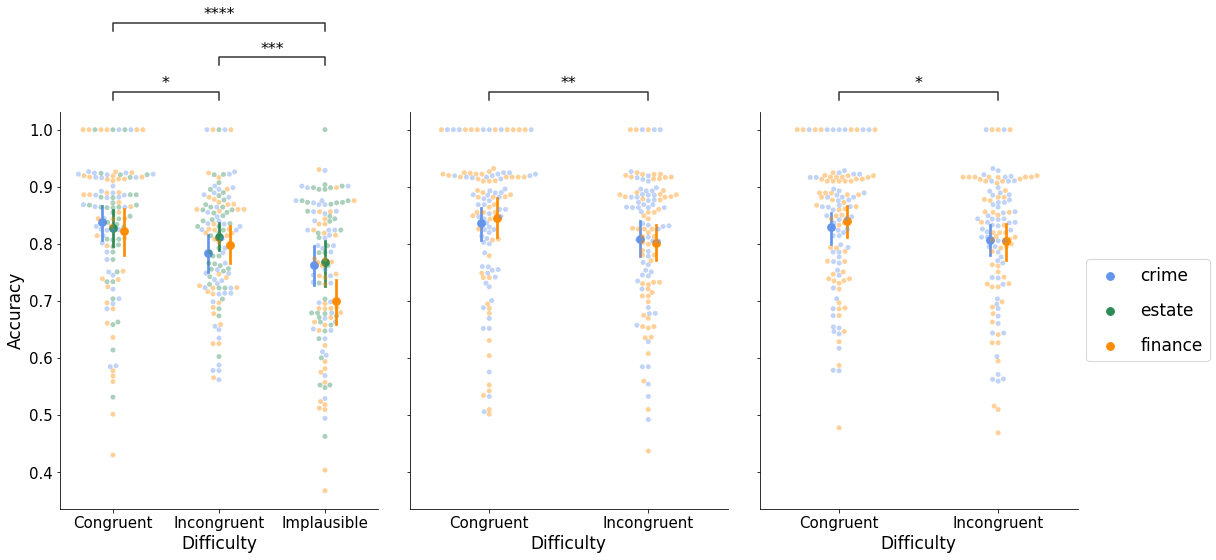

In [10]:
df_long_2.difficulty = df_long_2.difficulty.replace([1, 2, 3], ['Congruent', 'Incongruent', 'Implausible'])
x = 'difficulty'
y = 'accuracy'
hue = 'scenario'

order=['Congruent', 'Incongruent', 'Implausible']


fig, axs = plt.subplots(1, 3, figsize=(17, 8), sharey=True)

colors = [color_dict['crime'], color_dict['estate'], color_dict['finance']]
sns.set_palette(colors)
sns.swarmplot(x=x, y=y, data=df_long_2, hue=hue, alpha=.4, ax=axs[0], order=order)
sns.pointplot(x=x, y=y, data=df_long_2, hue=hue, dodge=0.2, join=None, ci=95, ax=axs[0], order=order)

box_pairs = [('Congruent', 'Incongruent'), ('Congruent', 'Implausible'), ('Incongruent', 'Implausible')]
p_values = [.0208, .00009, .0009]
add_stat_annotation(axs[0], data=df_long_2, x=x, y=y, box_pairs=box_pairs, perform_stat_test=False, test_short_name="Tukey's range test", pvalues=p_values, verbose=2, loc='outside', fontsize=16)

sns.despine()
axs[0].set_ylabel('Accuracy', fontsize=17)
axs[0].set_xlabel('Difficulty', fontsize=17)
#figure.suptitle('Difference in accuracy between difficulty conditions', fontsize=16)

handles, labels = axs[0].get_legend_handles_labels()
axs[0].legend([], [],frameon=False)

plt.setp(axs[0].get_yticklabels(), fontsize=15)
plt.setp(axs[0].get_xticklabels(), fontsize=15)

### EXPERIMETN 3
df_long_3.difficulty = df_long_3.difficulty.replace([1, 2], ['Congruent', 'Incongruent'])
x = 'difficulty'
y = 'accuracy'
hue = 'scenario'

colors = [color_dict['crime'], color_dict['finance']]
sns.set_palette(colors)
sns.swarmplot(x=x, y=y, data=df_long_3, hue=hue, alpha=.4, ax=axs[1], order=order[:2])
sns.pointplot(x=x, y=y, data=df_long_3, hue=hue, join=None, dodge=0.1, ci=95, ax=axs[1], order=order[:2])

box_pairs = [('Congruent', 'Incongruent')]
p_values = [.0097]
add_stat_annotation(ax=axs[1], data=df_long_3, x=x, y=y, box_pairs=box_pairs, perform_stat_test=False, test_short_name="Tukey's range test", pvalues=p_values, verbose=2, loc='outside', fontsize=16)

sns.despine()
axs[1].set_ylabel('')
axs[1].set_xlabel('Difficulty', fontsize=17)
axs[1].legend([], [] ,frameon=False)
#fig.suptitle('Difference in accuracy between difficulty conditions', fontsize=16)

plt.setp(axs[1].get_yticklabels(), fontsize=15)
plt.setp(axs[1].get_xticklabels(), fontsize=15)

### EXPERIMETN 4
df_long_4.difficulty = df_long_4.difficulty.replace([1, 2], ['Congruent', 'Incongruent'])
x = 'difficulty'
y = 'accuracy'
hue = 'scenario'

colors = [color_dict['crime'], color_dict['finance']]
sns.set_palette(colors)
sns.swarmplot(x=x, y=y, data=df_long_4, hue=hue, alpha=.4, ax=axs[2], order=order[:2])
sns.pointplot(x=x, y=y, data=df_long_4, hue=hue, join=None, dodge=0.1, ci=95, ax=axs[2], order=order[:2])

box_pairs = [('Congruent', 'Incongruent')]
p_values = [.0300]
add_stat_annotation(ax=axs[2], data=df_long_4, x=x, y=y, box_pairs=box_pairs, perform_stat_test=False, test_short_name="Tukey's range test", pvalues=p_values, verbose=2, loc='outside', fontsize=16)

sns.despine()
axs[2].set_ylabel('')
axs[2].set_xlabel('Difficulty', fontsize=17)
#fig.suptitle('Difference in accuracy between difficulty conditions', fontsize=16)

#handles, labels = axs[1].get_legend_handles_labels()
axs[2].legend(handles[0:3], labels[0:3], labelspacing=1, loc=6, bbox_to_anchor=(1, 0.5), fontsize=17)

plt.setp(axs[2].get_yticklabels(), fontsize=15)
plt.setp(axs[2].get_xticklabels(), fontsize=15)

plt.tight_layout()
plt.subplots_adjust(wspace = 0.1)
plt.savefig('./plots/lmer_parts.pdf')

## Hamming distance

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Congruent v.s. Incongruent: Custom statistical test, P_val:2.100e-03
Incongruent v.s. Implausible: Custom statistical test, P_val:1.110e-01
Congruent v.s. Implausible: Custom statistical test, P_val:9.000e-05
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Congruent v.s. Incongruent: Custom statistical test, P_val:2.000e-02
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Incongruent v.s. Congruent: Custom statistical test, P_val:2.084e-01


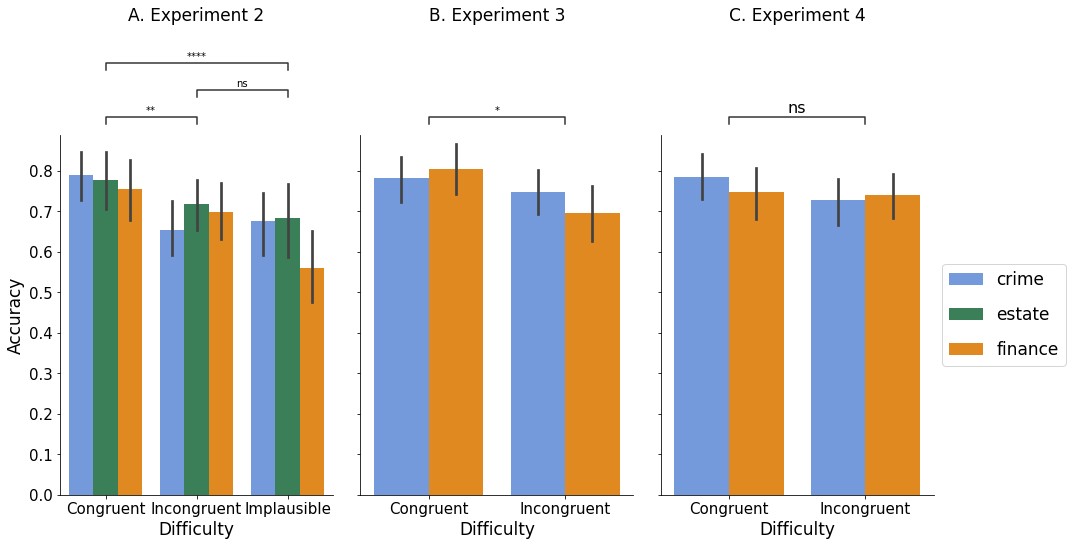

In [11]:
df_ee_2 = df_long_2_ham
df_ee_2.difficulty = df_ee_2.difficulty.replace([1, 2, 3], ['Congruent', 'Incongruent', 'Implausible'])
x = 'difficulty'
y = 'accuracy'
hue = 'scenario'

fig, axs = plt.subplots(1, 3, figsize=(15, 8), sharey=True)

colors = [color_dict['crime'], color_dict['estate'], color_dict['finance']]
sns.set_palette(colors)
sns.barplot(x=x, y=y, data=df_ee_2, hue=hue, ax=axs[0])

box_pairs = [('Congruent', 'Incongruent'), ('Congruent', 'Implausible'), ('Incongruent', 'Implausible')]
p_values = [.0021, .00009, .1110]
add_stat_annotation(axs[0], data=df_ee_2, x=x, y=y, box_pairs=box_pairs, perform_stat_test=False, test_short_name="Tukey's range test", pvalues=p_values, verbose=2, loc='outside')

sns.despine()
axs[0].set_ylabel('Accuracy', fontsize=17)
axs[0].set_xlabel('Difficulty', fontsize=17)
#figure.suptitle('Difference in accuracy between difficulty conditions', fontsize=16)

handles, labels = axs[0].get_legend_handles_labels()
axs[0].legend([], [],frameon=False)
axs[0].set_title('A. Experiment 2', fontsize=17, y=1.3)

plt.setp(axs[0].get_yticklabels(), fontsize=15)
plt.setp(axs[0].get_xticklabels(), fontsize=15)


### EXPERIMETN 3
df_ee_3 = df_long_3_ham
df_ee_3.difficulty = df_ee_3.difficulty.replace([1, 2], ['Congruent', 'Incongruent'])
x = 'difficulty'
y = 'accuracy'
hue = 'scenario'

colors = [color_dict['crime'], color_dict['finance']]
sns.set_palette(colors)
sns.barplot(x=x, y=y, data=df_ee_3, hue=hue, ax=axs[1], order=['Congruent', 'Incongruent'])
box_pairs = [('Congruent', 'Incongruent')]
p_values = [.02]
add_stat_annotation(ax=axs[1], data=df_ee_3, x=x, y=y, box_pairs=box_pairs, perform_stat_test=False, test_short_name="Tukey's range test", pvalues=p_values, verbose=2, loc='outside')

sns.despine()
axs[1].set_ylabel('')
axs[1].set_xlabel('Difficulty', fontsize=17)
#fig.suptitle('Difference in accuracy between difficulty conditions', fontsize=16)

#handles, labels = axs[1].get_legend_handles_labels()
axs[1].legend([], frameon=False)

plt.setp(axs[1].get_yticklabels(), fontsize=15)
plt.setp(axs[1].get_xticklabels(), fontsize=15)
axs[1].set_title('B. Experiment 3', fontsize=17, y=1.3)


#Experiment 4
df_long_4_ham.difficulty = df_long_4_ham.difficulty.replace([1, 2], ['Congruent', 'Incongruent'])
x = 'difficulty'
y = 'accuracy'
hue = 'scenario'

colors = [color_dict['crime'], color_dict['finance']]
sns.set_palette(colors)
sns.barplot(x=x, y=y, data=df_long_4_ham, hue=hue, ax=axs[2], order=['Congruent', 'Incongruent'])

box_pairs = [('Congruent', 'Incongruent')]
p_values = [.2084]
add_stat_annotation(ax=axs[2], data=df_long_4_ham, x=x, y=y, box_pairs=box_pairs, perform_stat_test=False, test_short_name="Tukey's range test", pvalues=p_values, verbose=2, loc='outside', fontsize=16)

sns.despine()
axs[2].set_ylabel('')
axs[2].set_xlabel('Difficulty', fontsize=17)
#fig.suptitle('Difference in accuracy between difficulty conditions', fontsize=16)

#handles, labels = axs[1].get_legend_handles_labels()
axs[2].legend(handles[0:3], labels[0:3], labelspacing=1, loc=6, bbox_to_anchor=(1, 0.5), fontsize=17)

plt.setp(axs[2].get_yticklabels(), fontsize=15)
plt.setp(axs[2].get_xticklabels(), fontsize=15)
axs[2].set_title('C. Experiment 4', fontsize=17, y=1.3)

plt.tight_layout()
plt.subplots_adjust(wspace = 0.1)
plt.savefig('./plots/lmer_parts_hamming.pdf')

# Priors 

## Same models with prior shape

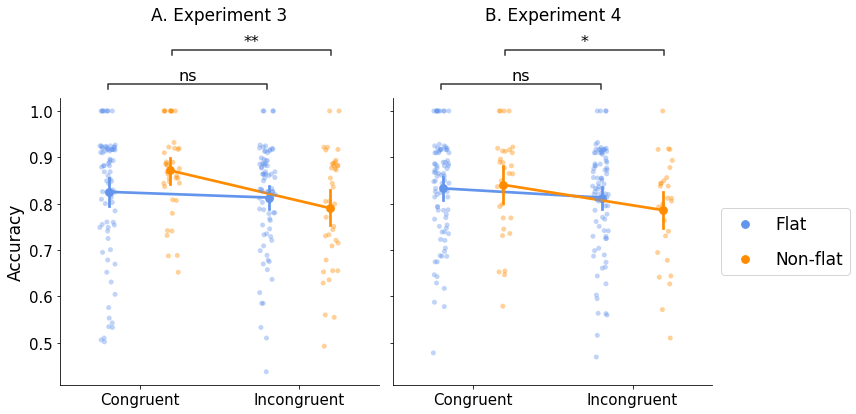

In [12]:

x = 'difficulty'
y = 'accuracy'
hue = 'lc_prior_bf'
prior_geq0 = [1, 0]
titles_priors = ['Prior best fit', 'No prior best fit']
prior_types = ['lc_prior_bf']
model_names = ['Adaptive Selective LC']
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
letter = ['A', 'B']

p_values_arr = [(.6516, .0018), (.2086, .0298)]
experiments = ['experiment_3', 'experiment_4']
for j, exp in enumerate(experiments):
    if j == 0:
        df_plot = df_long_3
    else:
        df_plot = df_long_4

    df_plot.lc_prior_bf.replace({0:'Flat', 1:'Non-flat'}, inplace=True)
    df_plot.difficulty.replace({1:'Congruent', 2:'Incongruent'}, inplace=True)
    order = ['Congruent', 'Incongruent']
    hue_order = ['Flat', 'Non-flat']
    sns.stripplot(x=x, y=y, data=df_plot, hue=hue, alpha=.4, ax=axs[j], dodge=True, order=order, hue_order=hue_order)
    sns.pointplot(x=x, y=y, data=df_plot, hue=hue, dodge=0.38, ci=95, ax=axs[j], order=order, hue_order=hue_order)

    box_pairs = [
        (('Congruent', 'Flat'), ('Incongruent', 'Flat')),
        (('Congruent', 'Non-flat'), ('Incongruent', 'Non-flat'))
    ]

    annotator = Annotator(axs[j], box_pairs, data=df_plot, x=x, y=y, hue=hue, order=order, hue_order=hue_order, verbose=False)
    annotator.configure(test_short_name="Tukey's range test", loc='outside', show_test_name=False, text_format='star', fontsize=16)
    annotator.set_pvalues(p_values_arr[j])
    annotator.annotate()
        
    #add_stat_annotation(axs[i, j], data=df_plot, x=x, y=y, box_pairs=box_pairs, perform_stat_test=False, test_short_name="Tukey's range test", pvalues=p_values, verbose=2, loc='outside')

    sns.despine()
    if j == 0:
        axs[j].set_ylabel('Accuracy', fontsize=17)
        axs[j].legend([], [], frameon=False)
    else:
        axs[j].set_ylabel('')
        axs[j].legend(handles[0:2], labels[0:2], labelspacing=1, loc=6, bbox_to_anchor=(1, 0.5), fontsize=17)
        
    if i == len(prior_types) - 1:
        axs[j].set_xlabel('Difficulty', fontsize=17)
    else:
        axs[j].set_xlabel('')

    plt.setp(axs[j].get_yticklabels(), fontsize=15)
    plt.setp(axs[j].get_xticklabels(), fontsize=15)

    handles, labels = axs[j].get_legend_handles_labels()
    #axs[j].legend(handles[0:2], labels[0:2])
    axs[j].set_title(f'{letter[j]}. Experiment {j+3}',  fontsize=17, y=1.25)

        

#fig.suptitle('Effect of difficulty for participants best fit with and without prior parameter', fontsize=18, y=1.01)


#fig.suptitle('Interaction of difficulty whether participants were best fit \nwith a flat or non-flat prior in predicting accuracy', fontsize=17)
plt.tight_layout()
plt.savefig('./plots/manip_effect_prior_bf_exp34.pdf')


# With Hamming distance

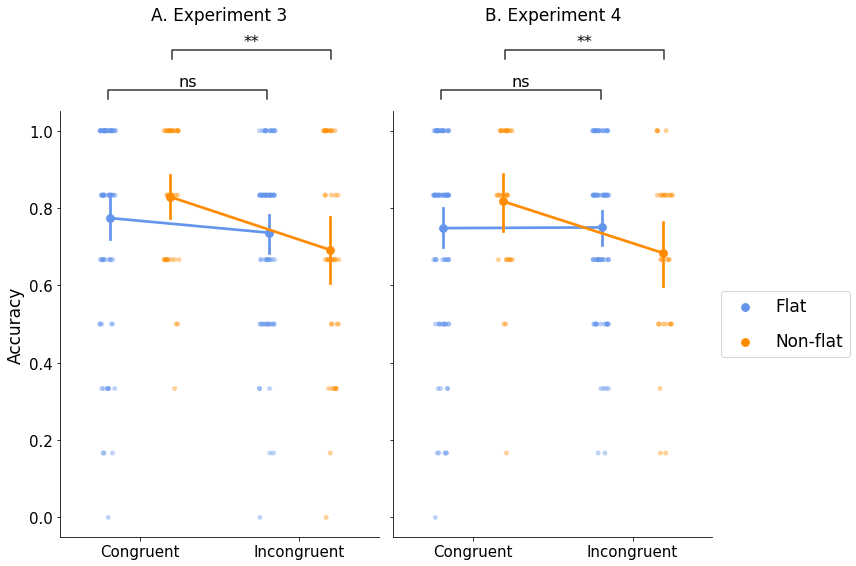

In [13]:

x = 'difficulty'
y = 'hamming'
hue = 'lc_prior_bf'
prior_geq0 = [1, 0]
titles_priors = ['Prior best fit', 'No prior best fit']
prior_types = ['lc_prior_bf']
model_names = ['Adaptive Selective LC']
fig, axs = plt.subplots(1, 2, figsize=(12, 8), sharey=True)
letter = ['A', 'B']

p_values_arr = [(.3410, .0088), (.9654, .0059)]
experiments = ['experiment_3', 'experiment_4']
for j, exp in enumerate(experiments):
    if j == 0:
        df_plot = df_long_3
    else:
        df_plot = df_long_4

    df_plot.lc_prior_bf.replace({0:'Flat', 1:'Non-flat'}, inplace=True)
    df_plot.difficulty.replace({1:'Congruent', 2:'Incongruent'}, inplace=True)
    order = ['Congruent', 'Incongruent']
    hue_order = ['Flat', 'Non-flat']
    sns.stripplot(x=x, y=y, data=df_plot, hue=hue, alpha=.4, ax=axs[j], dodge=True, order=order, hue_order=hue_order)
    sns.pointplot(x=x, y=y, data=df_plot, hue=hue, dodge=0.38, ci=95, ax=axs[j], order=order, hue_order=hue_order)

    box_pairs = [
        (('Congruent', 'Flat'), ('Incongruent', 'Flat')),
        (('Congruent', 'Non-flat'), ('Incongruent', 'Non-flat'))
    ]

    annotator = Annotator(axs[j], box_pairs, data=df_plot, x=x, y=y, hue=hue, order=order, hue_order=hue_order, verbose=False)
    annotator.configure(test_short_name="Tukey's range test", loc='outside', show_test_name=False, text_format='star', fontsize=16)
    annotator.set_pvalues(p_values_arr[j])
    annotator.annotate()
        
    #add_stat_annotation(axs[i, j], data=df_plot, x=x, y=y, box_pairs=box_pairs, perform_stat_test=False, test_short_name="Tukey's range test", pvalues=p_values, verbose=2, loc='outside')

    sns.despine()
    if j == 0:
        axs[j].set_ylabel('Accuracy', fontsize=17)
        axs[j].legend([], [], frameon=False)
    else:
        axs[j].set_ylabel('')
        axs[j].legend(handles[0:2], labels[0:2], labelspacing=1, loc=6, bbox_to_anchor=(1, 0.5), fontsize=17)
        
    if i == len(prior_types) - 1:
        axs[j].set_xlabel('Difficulty', fontsize=17)
    else:
        axs[j].set_xlabel('')

    plt.setp(axs[j].get_yticklabels(), fontsize=15)
    plt.setp(axs[j].get_xticklabels(), fontsize=15)

    handles, labels = axs[j].get_legend_handles_labels()
    #axs[j].legend(handles[0:2], labels[0:2])
    axs[j].set_title(f'{letter[j]}. Experiment {j+3}',  fontsize=17, y=1.20)

        

#fig.suptitle('Effect of difficulty for participants best fit with and without prior parameter', fontsize=18, y=1.01)


#fig.suptitle('Interaction of difficulty whether participants were best fit \nwith a flat or non-flat prior in predicting accuracy', fontsize=17)
plt.tight_layout()
plt.savefig('./plots/manip_effect_prior_bf_exp34_hamming.pdf')


# Indirect links errors in labelled trials for experiment 3 and 4

Mixed effect model can be found in mixed_effect_models_euclidean_norm.R, last analysis

c:\Utility\Python\python38\lib\site-packages\pandas\core\generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
C:\Users\vbtes\AppData\Local\Temp/ipykernel_20032/3104764186.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_yticklabels(axs[0].get_yticklabels(), fontsize=15)
c:\Utility\Python\python38\lib\site-packages\pandas\core\generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


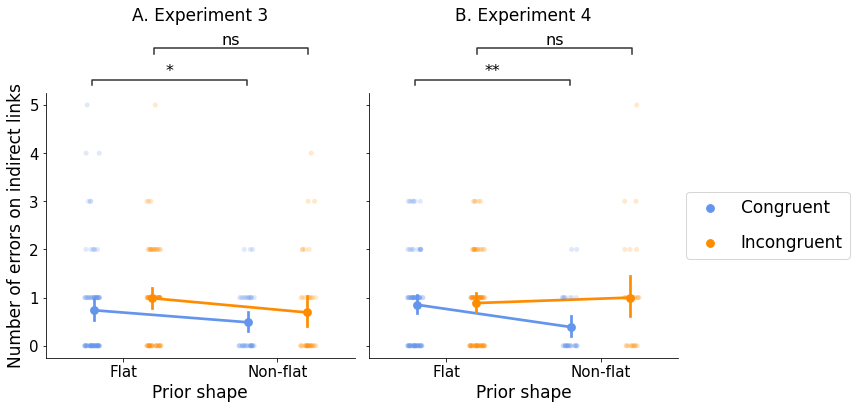

In [14]:
trials_labelled = df_trials[df_trials.trial_name.isin(['crime', 'finance'])]

hue_order = ['Congruent', 'Incongruent']
order = ['Flat', 'Non-flat']

fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

trials_3_prior = trials_labelled[trials_labelled.experiment == 'experiment_3']
trials_3_prior.lc_prior_bf.replace({0:'Flat', 1:'Non-flat'}, inplace=True)
trials_3_prior.trial_type.replace({'congruent':'Congruent', 'incongruent':'Incongruent'}, inplace=True)

sns.stripplot(x='lc_prior_bf', y='num_indirect_errors', hue='trial_type', data=trials_3_prior, ax=axs[0], alpha=0.2, dodge=0.2, hue_order=hue_order, order=order)
sns.pointplot(x='lc_prior_bf', y='num_indirect_errors', hue='trial_type', data=trials_3_prior, ax=axs[0], dodge=0.38, ci=95, hue_order=hue_order, order=order)

box_pairs = [
    (('Flat', 'Congruent'), ('Non-flat', 'Congruent')),
    (('Flat', 'Incongruent'), ('Non-flat', 'Incongruent')),
]

p_values = [0.0444, 0.1985]

annotator = Annotator(axs[0], box_pairs, data=trials_3_prior, x='lc_prior_bf', y='num_indirect_errors', hue='trial_type', order=order, hue_order=hue_order, verbose=False)
annotator.configure(test_short_name="Tukey's range test", loc='outside', show_test_name=False, text_format='star', fontsize=16)
annotator.set_pvalues(p_values)
annotator.annotate()

handles, labels = axs[0].get_legend_handles_labels()
axs[0].legend([], [], frameon=False, fontsize=17)
axs[0].set_title('A. Experiment 3', fontsize=17, y=1.25)
axs[0].set_ylabel('Number of errors on indirect links',  fontsize=17)
axs[0].set_xlabel('Prior shape',  fontsize=17)
axs[0].set_xticklabels(order,  fontsize=15)
axs[0].set_yticklabels(axs[0].get_yticklabels(), fontsize=15)


trials_4_prior = trials_labelled[trials_labelled.experiment == 'experiment_4']
trials_4_prior.lc_prior_bf.replace({0:'Flat', 1:'Non-flat'}, inplace=True)
trials_4_prior.trial_type.replace({'congruent':'Congruent', 'incongruent':'Incongruent'}, inplace=True)

sns.stripplot(x='lc_prior_bf', y='num_indirect_errors', hue='trial_type', data=trials_4_prior, ax=axs[1], alpha=0.2, dodge=0.2, hue_order=hue_order, order=order)
sns.pointplot(x='lc_prior_bf', y='num_indirect_errors', hue='trial_type', data=trials_4_prior, ax=axs[1], dodge=0.38, ci=95, hue_order=hue_order, order=order)


p_values = [0.0025, 0.6233]

annotator = Annotator(axs[1], box_pairs, data=trials_4_prior, x='lc_prior_bf', y='num_indirect_errors', hue='trial_type', order=order, hue_order=hue_order, verbose=False)
annotator.configure(test_short_name="Tukey's range test", loc='outside', show_test_name=False, text_format='star', fontsize=16)
annotator.set_pvalues(p_values)
annotator.annotate()

handles, labels = axs[1].get_legend_handles_labels()
axs[1].legend(handles[0:2], labels[0:2], fontsize=17, labelspacing=1, loc=6, bbox_to_anchor=(1, 0.5))
axs[1].set_title('B. Experiment 4', fontsize=17, y=1.25)
axs[1].set_ylabel('',  fontsize=17)
axs[1].set_xlabel('Prior shape',  fontsize=17)
axs[1].set_xticklabels(order,  fontsize=15)
#axs[1].set_yticklabels(axs[1].get_yticklabels(), fontsize=15)

#fig.suptitle('Number of errors on indirect links for participants best fit with and without a non-flat prior parameter', fontsize=17)
sns.despine()
plt.tight_layout()
plt.savefig('./plots/indirect_links_errors_34.pdf')
plt.show()

# Root node frequencies

Aggregate interventional data

In [15]:
# IMport fresh datasets
df_long_3 = pd.read_csv('./data/accuracy_lf_exp3_wprior.csv')
df_long_4 = pd.read_csv('./data/accuracy_lf_exp4_wprior.csv')

trial_types = interventions.groupby('utid').trial_type.unique().to_list()
trial_types = np.concatenate(trial_types).flatten()

utids = interventions.utid.unique()
print(utids.size)
df_inters = pd.DataFrame()
new_vars_dict = {}
new_vars = np.empty((utids.size, 50))
new_vars[:] = np.nan
var_order = np.empty((utids.size, 50))
var_order[:] = np.nan

var_pos = np.empty((utids.size, 50))
var_pos[:] = np.nan

var_name_pos = np.empty((utids.size, 50)).astype(str)
var_root_pos = np.empty((utids.size, 50)).astype(str)
var_gtroot_pos = np.empty((utids.size, 50)).astype(str)

nums = []
for i, unique_trial in enumerate(utids):
    df_chunk = interventions[interventions.utid == unique_trial].sort_values('int_num')
    new_var = []
    intervened_var = []
    var_positions = []
    for j, inter in enumerate(df_chunk.index):
        var_touched = df_chunk.loc[inter, 'variable']  
        var_prior_type = df_chunk.loc[inter, 'prior_type']
        var_gt_type = df_chunk.loc[inter, 'gt_type']

        if var_touched not in intervened_var:
            intervened_var.append(var_touched)
            new_var.append(1)
            new_vars[i, j] = 1
        else:
            new_var.append(0)
            new_vars[i, j] = 0

        
        var_place = df_chunk.loc[inter, 'var_position']
        var_pos[i, j] = var_place + 1
        var_name_pos[i, j] = var_touched
        var_root_pos[i, j] = var_prior_type
        var_gtroot_pos[i, j] = var_gt_type
        if not var_positions:
            if var_place == 0:
                var_order[i, j] = 1
            else:
                var_order[i, j] = 0
            
        elif var_place >= var_positions[-1]:
            var_order[i, j] = 1
        else:
            var_order[i, j] = 0
            
        var_positions.append(var_place)
    
    nums.append(len(new_var))
    
    new_vars_dict[unique_trial] = new_var


experiments = [int(utid[0]) for utid in utids]
pids = [utid.split('-')[1] for utid in utids]

prior_bf = np.zeros(len(pids))
for i, pid in enumerate(pids):
    if pid in df_long_3.participant.to_list():
        prior_bf[i] = df_long_3.loc[df_long_3.participant == pid, 'lc_prior_bf'].to_list()[0]
    elif pid in df_long_4.participant.to_list():
        prior_bf[i] = df_long_4.loc[df_long_4.participant == pid, 'lc_prior_bf'].to_list()[0]
    else:
        prior_bf[i] = np.nan


df_order = pd.DataFrame(columns=['experiment', 'utid', 'pid', 'prior_bf', 'trial_type'] + [f'inter_{i}' for i in range(35)])
df_order['experiment'] = experiments
df_order['utid'] = utids
df_order['pid'] = pids
df_order['prior_bf'] = prior_bf
df_order['trial_type'] = trial_types

df_order_name = pd.DataFrame(columns=['experiment', 'utid', 'pid', 'prior_bf', 'trial_type'] + [f'inter_{i}' for i in range(35)])
df_order_name['experiment'] = experiments
df_order_name['utid'] = utids
df_order_name['pid'] = pids
df_order_name['prior_bf'] = prior_bf
df_order_name['trial_type'] = trial_types

df_order_root = pd.DataFrame(columns=['experiment', 'utid', 'pid', 'prior_bf', 'trial_type'] + [f'inter_{i}' for i in range(35)])
df_order_root['experiment'] = experiments
df_order_root['utid'] = utids
df_order_root['pid'] = pids
df_order_root['prior_bf'] = prior_bf
df_order_root['trial_type'] = trial_types

df_order_gtroot = pd.DataFrame(columns=['experiment', 'utid', 'pid', 'prior_bf', 'trial_type'] + [f'inter_{i}' for i in range(35)])
df_order_gtroot['experiment'] = experiments
df_order_gtroot['utid'] = utids
df_order_gtroot['pid'] = pids
df_order_gtroot['prior_bf'] = prior_bf
df_order_gtroot['trial_type'] = trial_types

for i, col in enumerate([f'inter_{i}' for i in range(35)]):
    df_order.loc[df_order.index, col ] = var_pos[:, i]
    df_order_name.loc[df_order_name.index, col ] = var_name_pos[:, i]
    df_order_root.loc[df_order_root.index, col] = var_root_pos[:, i]
    df_order_gtroot.loc[df_order_gtroot.index, col] = var_gtroot_pos[:, i]
    #print(var_root_pos[:, i])

df_order_new = pd.DataFrame(columns=['experiment', 'utid', 'pid', 'prior_bf', 'trial_type'] + [f'inter_{i}' for i in range(35)])

df_order_new['experiment'] = experiments
df_order_new['utid'] = utids
df_order_new['pid'] = pids
df_order_new['prior_bf'] = prior_bf
df_order_new['trial_type'] = trial_types
for i, col in enumerate([f'inter_{i}' for i in range(35)]):
    df_order_new.loc[df_order_new.index, col ] = new_vars[:, i]


label_trials = ['label', 'congruent', 'incongruent', 'implausible']
df_order.trial_type.unique()
generic_trials = ['generic_0', 'generic_1', 'generic_2', 'generic_3']

df_order_generic = df_order[df_order.trial_type.isin(generic_trials)]
df_order_labels = df_order[df_order.trial_type.isin(label_trials)]

df_order_new_generic = df_order_new[df_order_new.trial_type.isin(generic_trials)]
df_order_new_labels = df_order_new[df_order_new.trial_type.isin(label_trials)]

df_c = df_order[df_order.trial_type == label_trials[1]]
df_congruent_3 = df_c[df_c.experiment == 3]
df_i =  df_order[df_order.trial_type == label_trials[2]]
df_incongruent_3 = df_i[df_i.experiment == 3]


idx_inter = 15
K = 3
count_generic = np.zeros((K, idx_inter))
count_label = np.zeros((K, idx_inter))

count_variable = np.zeros((2, K, idx_inter))

count_var_exp3 = np.zeros((2, K, idx_inter))


for i, col in enumerate(df_order_generic.columns[3:3+idx_inter]):
    for k in range(K):
        count_generic[k, i] = df_order_generic[df_order_generic[f'inter_{i}'] == k+1].shape[0]
        count_label[k, i] = df_order_labels[df_order_labels[f'inter_{i}'] == k+1].shape[0]

        count_variable[0, k, i] = df_order_generic[df_order_generic[f'inter_{i}'] == k+1].shape[0]
        count_variable[1, k, i] = df_order_labels[df_order_labels[f'inter_{i}'] == k+1].shape[0]

        count_var_exp3[0, k, i] = df_congruent_3[df_congruent_3[f'inter_{i}'] == k+1].shape[0]
        count_var_exp3[1, k, i] = df_incongruent_3[df_incongruent_3[f'inter_{i}'] == k+1].shape[0]





1714


C:\Users\vbtes\AppData\Local\Temp/ipykernel_20032/4237197515.py:74: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


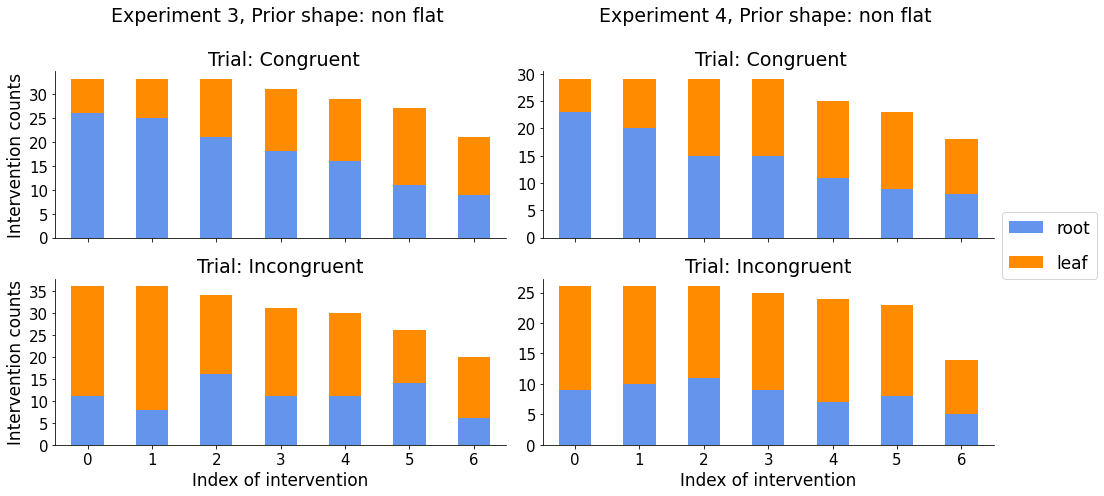

In [16]:
new_df = df_order_gtroot[(df_order_gtroot == 'root') | (df_order_gtroot == 'leaf')]
new_df[['experiment', 'utid', 'pid', 'prior_bf', 'trial_type']] = df_order_root[['experiment', 'utid', 'pid', 'prior_bf', 'trial_type']]

df_root_counts = new_df[new_df.experiment.isin([3, 4])].replace({'nan':np.nan})

df_root_counts.prior_bf.replace({0:'flat', 1:'non flat'}, inplace=True)

prior_bfs = ['non flat']
trials = ['congruent', 'incongruent']
experiment_idx = [3, 4]

loc_idx_inter = 7

fig, axs = plt.subplots(2, 2, constrained_layout=True, figsize=(14, 7), sharex=True)

hue_order = ['root', 'leaf']

for i, trial in enumerate(trials):
    df_root_counts_trial = df_root_counts[df_root_counts.trial_type == trial]

    df_root_trial_prior = df_root_counts_trial[df_root_counts_trial.prior_bf == prior_bfs[0]]

    for j, exp_idx in enumerate(experiment_idx):
        #print(exp_idx)
        df_root_trial_prior_exp = df_root_trial_prior[df_root_trial_prior.experiment == exp_idx]
        #print(df_root_trial_prior_exp.shape)
        
        #print(df_root_trial_prior.shape)

        mapper = {k:v for k, v in zip(df_root_counts_trial.columns[5:loc_idx_inter+5], np.arange(df_root_counts_trial.columns[5:loc_idx_inter+5].size))}
        df_counts_plot_c = df_root_trial_prior_exp[df_root_trial_prior_exp.columns[5:loc_idx_inter + 5]].rename(mapper, axis=1)
        df_counts_plot = df_counts_plot_c.melt()

        
        rows = ['root', 'leaf']
        df_final = pd.DataFrame(index=rows, columns=df_counts_plot_c.columns)
        for col in df_counts_plot_c.columns:
            counts = df_counts_plot_c[col].value_counts()

            #print(counts)
            #print(counts.loc['root'])
            for r in rows:
                if r in counts.index:
                    df_final.loc[r, col] = counts.loc[r]


        df_final.transpose().plot(kind='bar', stacked=True, ax=axs[i, j])


        #sns.countplot(x='variable', hue='value', data=df_counts_plot.dropna(), hue_order=hue_order, ax=axs[i, j])
        #df_counts_plot.plot(kind='bar', stacked=True, ax=axs[i, j])
        if i == 0:
            axs[i, j].set_title(f'Experiment {exp_idx}, Prior shape: {prior_bfs[0]} \n\n Trial: {trial.capitalize()}', fontsize=19)
        else:
            axs[i, j].set_title(f'Trial: {trial.capitalize()}', fontsize=19)
            axs[i, j].set_xlabel('Index of intervention', fontsize=17)

        handles, labels = axs[i,j].get_legend_handles_labels()
        if j == 0:
            axs[i, j].set_ylabel('Intervention counts', fontsize=17)
            axs[i, j].legend([], [],frameon=False)

        if i == 0:
            axs[i, j].legend([], [],frameon=False)
            
        plt.setp(axs[i, j].get_yticklabels(), fontsize=15)
        plt.setp(axs[i, j].get_xticklabels(), fontsize=15, rotation=0)

        

sns.despine()
        

plt.tight_layout()

axs[1, 1].legend(handles[0:2], labels[0:2], labelspacing=1, loc=6, bbox_to_anchor=(1, 1.2), fontsize=17)
plt.savefig('./plots/interventions_roots.pdf')
plt.show()